# trying out

0.007055609187036518


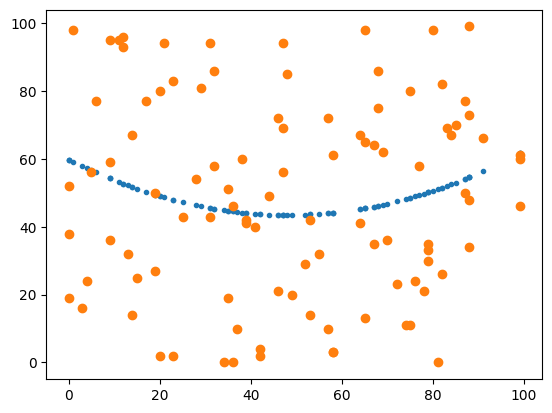

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

np.random.seed(0)

x = np.random.randint(0, 100, 100) # sample dataset for independent variables
y = np.random.randint(0, 100, 100) # sample dataset for dependent variables

def func(theta, x, y):
    # Return residual = fit-observed
    return (theta[0]*x**2 + theta[1]*x + theta[2]) - y

# Initial parameter guess
theta0 = np.array([0.5, -0.1, 0.3])

# Compute solution providing initial guess theta0, x input, and y input
sol = least_squares(func, theta0, args=(x,y))
print(sol.x[0])

plt.plot(x,sol.x[0]*x**2+sol.x[1]*x+sol.x[2],'.')
plt.plot(x,y,'o')

# FaIR models the GHG emission → concentration → effective radiative forcing (ERF), aerosol emission → ERF, and ERF → temperature responses of the climate system

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.793e+00 -7.056e+00 ...  6.505e+00  5.398e+01]
           x: [ 4.739e+01  6.836e-02  2.602e-02]
        cost: 86533.40416559594
         jac: [[ 1.000e+00  4.400e+01  3.100e+01]
               [ 1.000e+00  4.700e+01  1.300e+01]
               ...
               [ 1.000e+00  7.000e+01  5.100e+01]
               [ 1.000e+00  8.500e+01  3.000e+01]]
        grad: [-5.694e-06 -1.218e-04 -3.129e-04]
  optimality: 0.0003129005290247733
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 7
        njev: 6


/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_97622/1192903565.py:34: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 3 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  fig.colorbar(surf, shrink=0.5, aspect=5)


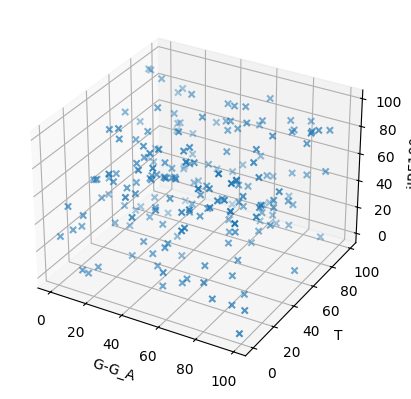

In [51]:
# iIRF100 = r0 + ru*G_u + rT*T

np.random.seed(0)

G_U = np.random.randint(0, 100, 200) 
T = np.random.randint(0, 100, 200) 
iIRF100 = np.random.randint(0, 100, 200)

def func(r,G_U,T,iIRF100):
    return(r[0]+r[1]*G_U+r[2]*T)-iIRF100

r=np.array([1,1,1])
sol = least_squares(func, r, args=(G_U,T,iIRF100))
print(sol)

#visualise in 3d
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
iIRF100low=min(iIRF100)
iIRF100high=max(iIRF100)

for m, iIRFlow, iIRFhigh in [('x', 0, 100)]:    
    xs = G_U
    ys = T
    zs = iIRF100
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('G-G_A ')
ax.set_ylabel('T ')
ax.set_zlabel('iIRF100 ')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


# FAIR Linear Functions

In [52]:
def calculate_alpha(G,G_A,T,r,g0,g1,iirf100_max = False):

    iirf100_val=r[0]+r[1]*(G-G_A)+r[2]*T+r[3]*G_A
  
    if iirf100_max: # if a max is given in input, otherwise false

        if iirf100_val>iirf100_max:
            iirf100_val=iirf100_max
        
    alpha_val = g0 * np.exp(iirf100_val / g1)
        
    return alpha_val

In [53]:
def step_concentration(R_old,G_A_old,E,alpha,a,tau,PI_conc,emis2conc,dt=1): #set time step to 1 year default

    decay_rate = dt/(alpha*tau)
    decay_factor = np.exp(-decay_rate)
    R_new = E * a / decay_rate * ( 1. - decay_factor ) + R_old * decay_factor # there shouldn't be a dt in the first decay rate
    G_A = np.sum(R_new) #summing across 4th dimension of matrix (like across columns or rows)
    C = PI_conc + emis2conc * (G_A + G_A_old) / 2 #concentration changes

    return C,R_new,G_A

In [54]:
def unstep_concentration(R_old,G_A,alpha,a,tau,PI_conc,emis2conc,dt=1):
    
    decay_rate = dt/(alpha*tau)
    decay_factor = np.exp( -decay_rate )
    E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 )) #summed from back to front
    R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor #creating extra dimension to E in R_new

    return E,R_new

In [55]:
def step_forcing(C,PI_conc,f):
    
    # if the logarithmic/sqrt term is undefined (ie. C is zero or negative), this contributes zero to the overall forcing. An exception will appear, however.

    #how could we have negative conc (is this just a possible math result that can't happen physically?)
    if (C/PI_conc)>0:
        logforc=f[0]*np.log(C/PI_conc)
    else:
        logforc=0
        
    linforc=f[1]*(C-PI_conc)
    
    if C>0:
        sqrtforc=f[2]*(np.sqrt(C)-np.sqrt(PI_conc))
    else:
        sqrtforc=f[2]*(0-np.sqrt(PI_conc))
    
    RF = logforc + linforc + sqrtforc #relative forcing is sum of all these (why?)

    return RF

In [56]:
def step_temperature(S_old,F,q,d,dt=1):
    
    decay_factor = np.exp(-dt/d) #we use all d values here (dj sum in papers)
    S_new = q * F * (1 - decay_factor) + S_old * decay_factor #temerpature response
    T = np.sum( (S_old + S_new)/2)

    return S_new,T

## Try calling functions

In [57]:
def return_gas_namelist():

    gas_namelist = ['bc',
                    'bc|aci',
                    'bc|bc_on_snow',
                    'c2f6',
                    'c3f8',
                    'c4f10',
                    'c5f12',
                    'c6f14',
                    'c7f16',
                    'c8f18',
                    'c_c4f8',
                    'carbon_dioxide',
                    'carbon_tetrachloride',
                    'carbon_tetrachloride|o3',
                    'cf4',
                    'cfc11',
                    'cfc113',
                    'cfc113|o3',
                    'cfc114',
                    'cfc114|o3',
                    'cfc115',
                    'cfc115|o3',
                    'cfc11|o3',
                    'cfc12',
                    'cfc12|o3',
                    'ch2cl2',
                    'ch2cl2|o3',
                    'ch3ccl3',
                    'ch3ccl3|o3',
                    'chcl3',
                    'chcl3|o3',
                    'co',
                    'co|o3',
                    'halon1202',
                    'halon1202|o3',
                    'halon1211',
                    'halon1211|o3',
                    'halon1301',
                    'halon1301|o3',
                    'halon2402',
                    'halon2402|o3',
                    'hcfc141b',
                    'hcfc141b|o3',
                    'hcfc142b',
                    'hcfc142b|o3',
                    'hcfc22',
                    'hcfc22|o3',
                    'hfc125',
                    'hfc134a',
                    'hfc143a',
                    'hfc152a',
                    'hfc227ea',
                    'hfc23',
                    'hfc236fa',
                    'hfc245fa',
                    'hfc32',
                    'hfc365mfc',
                    'hfc4310mee',
                    'methane',
                    'methane|strat_h2o',
                    'methane|o3',
                    'methyl_bromide',
                    'methyl_bromide|o3',
                    'methyl_chloride',
                    'methyl_chloride|o3',
                    'nf3',
                    'nh3',
                    'nitrous_oxide',
                    'nitrous_oxide|o3',
                    'nmvoc',
                    'nmvoc|o3',
                    'nox',
                    'nox_avi',
                    'nox_avi|contrails',
                    'nox|o3',
                    'oc',
                    'oc|aci',
                    'sf6',
                    'so2',
                    'so2f2',
                    'so2|aci'
                   ]
    return gas_namelist

In [58]:
def return_empty_emissions(df_to_copy=False, start_year=1765, end_year=2500, timestep=1, scen_names=[0] #sets values to all 0s
                           , gases_in = return_gas_namelist()): #sets default values to =...
    
    if type(df_to_copy)==pd.core.frame.DataFrame: #if already in correct format
        df = pd.DataFrame(index = df_to_copy.index,
                          columns=pd.MultiIndex.from_product([df_to_copy.columns.levels[0],gases_in],
                                                             names=['Scenario','Gas'])
                         ).fillna(0).apply(pd.to_numeric) 
        
    else:

        df = pd.DataFrame(index=np.arange(start_year,end_year+1,timestep), #put into correct format
                          columns=pd.MultiIndex.from_product([scen_names,gases_in],
                                                             names=['Scenario','Gas']) #same as above
                         ).fillna(0).apply(pd.to_numeric)
        df.index.rename('Year',inplace=True)

    return df

In [61]:
def return_empty_forcing(df_to_copy=False, start_year=1765, end_year=2500, timestep=1, scen_names=[0]): #dont need gas names here
    
    if type(df_to_copy)==pd.core.frame.DataFrame:
        df = pd.DataFrame(index = df_to_copy.index,
                          columns=pd.MultiIndex.from_product([df_to_copy.columns.levels[0],['forcing']],
                                                             names=['Scenario','Variable']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        
    else:
        
        df = pd.DataFrame(index=np.arange(start_year,end_year+1,timestep),
                          columns=pd.MultiIndex.from_product([scen_names,['forcing']],
                                                             names=['Scenario','Gas']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        df.index.rename('Year',inplace=True)

    return df

In [62]:
# Let's carry out a few basic runs now, starting with pulse emissions for each gas.

# First generate an empty emissions dataframe with four different scenarios

pulse_emissions = return_empty_emissions(df_to_copy=False, start_year=1765, end_year=2500, timestep=1, scen_names=['None']+[x+'pulse' for x in ['carbon_dioxide','methane','nitrous_oxide']], gases_in = ['carbon_dioxide','methane','nitrous_oxide'])

# add pulses in year 10 (the units are GtC, MtCH4 and MtN2O-N2):

for gas in ['carbon_dioxide','methane','nitrous_oxide']:
    
    pulse_emissions.loc[2000,(gas+'pulse',gas)] += 10
    
# Now generate a compatible forcing dataframe:

pulse_forcing = return_empty_forcing(pulse_emissions)

# And run the model!

pulse_run = run_FaIR(emissions_in=pulse_emissions,forcing_in=pulse_forcing,gas_parameters=test_gas_parameters,thermal_parameters=test_thermal_parameters)

/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_97622/1143959677.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_97622/1444158091.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)


NameError: name 'run_FaIR' is not defined

In [63]:
co2_in=[0,0,10,0,0,0,0,0,0,0,0]
n_year = len(co2_in)
n_year

11